In [1]:
import Dates
println("Last updated: ", Dates.now(), " (PT)")

Last updated: 2020-06-15T15:46:02.586 (PT)


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [115]:
# Import Libraries
using Turing
using Turing: Variational
using Distributions
using JSON3
using PyPlot
using StatsFuns
import Random
using BenchmarkTools
using Flux
include(joinpath(@__DIR__, "../util/BnpUtil.jl"));

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260


In [172]:
# DP GMM model under stick-breaking construction
@btime @model dp_gmm_sb(y, K) = begin
    nobs = length(y)

    mu ~ filldist(Normal(0, 3), K)
    sig ~ filldist(Gamma(1, 1/10), K)  # mean = 0.1
    
    alpha ~ Gamma(1, 1/10)  # mean = 0.1
    v ~ filldist(Beta(1, alpha), K - 1)
    eta = BnpUtil.stickbreak(v)

    # NOTE: Slow. And the MCMC gets stuck?
    # y .~ MixtureModel(Normal.(mu, sig), eta)

    # NOTE: Fast, and seems to mix well.
    log_target = logsumexp(normlogpdf.(mu', sig', y) .+ log.(eta)', dims=2)
    Turing.acclogp!(_varinfo, sum(log_target))
end
;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /home/ubuntu/.julia/packages/DynamicPPL/h0R38/src/compiler.jl:181


  105.348 ns (5 allocations: 96 bytes)


In [173]:
# Directory where all simulation data are stored.
data_dir = joinpath(@__DIR__, "../../data/sim-data")
path_to_data = joinpath(data_dir, "gmm-data-n200.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), path_to_data)
    JSON3.read(x, Dict{Symbol, Vector{Any}})
end

Dict{Symbol,Array{Any,1}} with 5 entries:
  :w        => Any[0.204919, 0.195407, 0.194413, 0.222356, 0.182905]
  :mu       => Any[-1.97027, -0.96176, -0.0597634, 0.998955, 1.9161]
  :sig      => Any[0.121097, 0.195192, 0.19999, 0.125166, 0.198667]
  :y        => Any[-1.25496, -1.03452, -1.21095, -1.89215, 0.321395, -1.27175, …
  :rand_idx => Any[2, 2, 2, 1, 3, 2, 5, 5, 2, 5  …  4, 3, 5, 1, 4, 4, 2, 2, 2, …

In [174]:
# Convert data to vector of floats
y = Float64.(data[:y]);

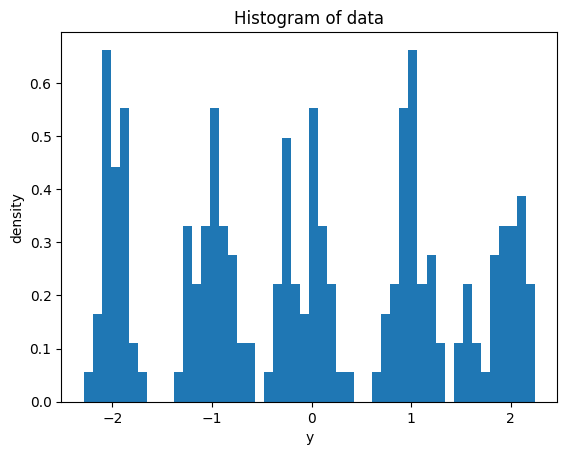

In [175]:
# Visualize data
plt.hist(y, bins=50, density=true)
plt.xlabel("y")
plt.ylabel("density")
plt.title("Histogram of data");

In [189]:
# Fit DP-SB-GMM with ADVI

# Set random seed for reproducibility
Random.seed!(1);

# Compile time approx.
# Run time approx.

# Define mean approximation for posterior
m = dp_gmm_sb(y, 10)
q0 = Variational.meanfield(m)

advi = ADVI(5, 1000)
@time q = vi(m, advi, optimizer=Flux.ADAM(1e-2));

[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:08


  8.960993 seconds (6.02 M allocations: 12.746 GiB, 11.09% gc time)


In [190]:
# Function for generating samples from approximate posterior
nsamples = 500
qsamples = rand(q, nsamples)
_, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
extract(sym) = qsamples[collect(sym2range[sym][1]), :]

# Extract eta
vpost = extract(:v)
etapost = hcat([BnpUtil.stickbreak(vpost[:, col]) for col in 1:size(vpost, 2)]...)';


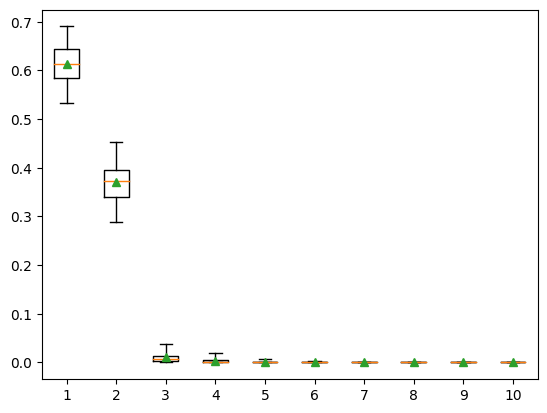

In [192]:
plt.boxplot(etapost, whis=[2.5, 97.5], showmeans=true, showfliers=false);

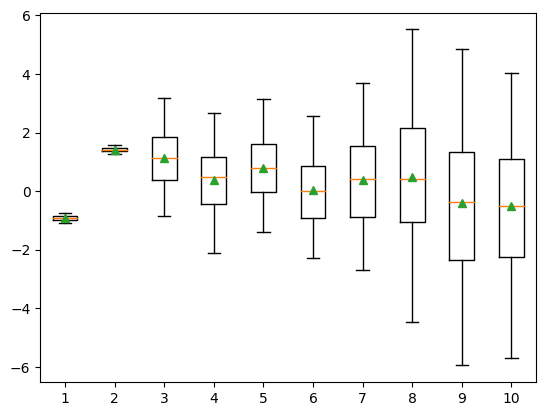

In [184]:
plt.boxplot(extract(:mu)', whis=[2.5, 97.5], showmeans=true, showfliers=false);

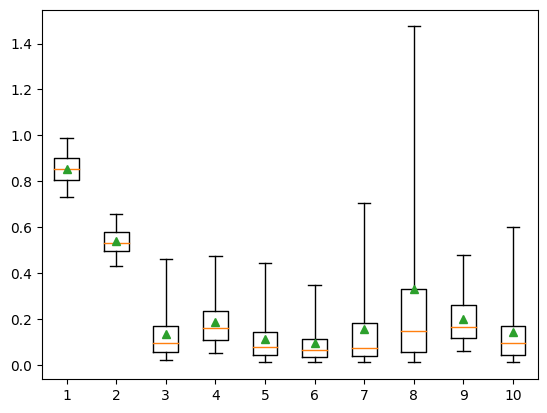

In [185]:
plt.boxplot(extract(:sig)', whis=[2.5, 97.5], showmeans=true, showfliers=false);

In [ ]:
# Fit DP-SB-GMM with HMC

# Set random seed for reproducibility
Random.seed!(0);

# Compile time approx. 32s.
# Run time approx. 70s.

@time chain = begin
    burn = 500  # NOTE: The burn in is also returned. Can't be discarded.
    n_samples = 500
    iterations = burn + n_samples
    n_components = 10
    stepsize = 0.01
    nleapfrog = floor(Int, 1 / stepsize)
 
    sample(dp_gmm_sb(y, n_components), 
           HMC(stepsize, nleapfrog),
           iterations)
end

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/d4vqQ/src/inference/hmc.jl:626
Sampling:   1%|▎                                        |  ETA: 0:00:14┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
Sampling:   4%|█▊                                       |  ETA: 0:06:48┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
Sampling:   6%|██▋                                      |  ETA: 0:07:40┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/WJCQA/src/hamiltoni

In [ ]:
# Fit DP-SB-GMM with NUTS

# Set random seed for reproducibility
Random.seed!(0);

# NUTS
# Compile time approx. 11s
# Run time approx. 244s
# Slower, but works a little better.
@time chain = begin
    n_components = 10
    n_samples = 500
    nadapt = 500
    iterations = n_samples + nadapt
    burn = 0  # For compatibility with HMC below.
    target_accept_ratio = 0.8
    
    sample(dp_gmm_sb(y, n_components),
           NUTS(nadapt, target_accept_ratio, max_depth=10),
           # NUTS(nadapt, target_accept_ratio, max_depth=5),  # 50 seconds, but poor inference.
           iterations);
end

In [40]:
function extract(chain, sym; burn=0)
    tail  = chain[sym].value.data[(burn + 1):end, :, :]
    return dropdims(tail, dims=3)
end

extract (generic function with 1 method)

In [41]:
vpost = extract(chain, :v, burn=burn);
mupost = extract(chain, :mu, burn=burn);
sigpost = extract(chain, :sig, burn=burn);
etapost = hcat([BnpUtil.stickbreak(vpost[row, :]) for row in 1:size(vpost, 1)]...)';

In [42]:
function plot_param_post(param, param_name, param_full_name; figsize=(11, 4), truth=nothing)
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[2.5, 97.5], showmeans=true, showfliers=false)
    plt.xlabel("mixture components")
    plt.ylabel(param_full_name)
    plt.title("95% Credible Intervals for $(param_full_name)")
    
    if truth != nothing
        for line in truth
            plt.axhline(line, ls=":")
        end
    end

    plt.subplot(1, 2, 2)
    plt.plot(param)
    plt.xlabel("iterations")
    plt.ylabel(param_full_name)
    plt.title("Trace plot of $(param_full_name)");
end

plot_param_post (generic function with 1 method)

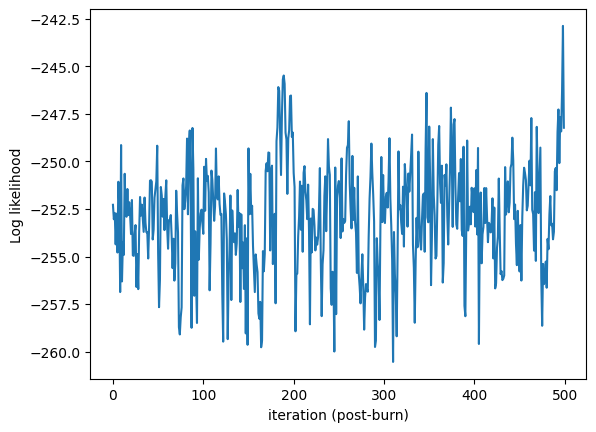

PyObject Text(24.0, 0.5, 'Log likelihood')

In [48]:
# Loglikelihood can be extracted after model fitting using string macro.
# See: https://turing.ml/dev/docs/using-turing/guide#querying-probabilities-from-model-or-chain

loglike = logprob"y=y, K=n_components | model=dp_gmm_sb, chain=chain"
plt.plot(loglike)
plt.xlabel("iteration (post-burn)")
plt.ylabel("Log likelihood")

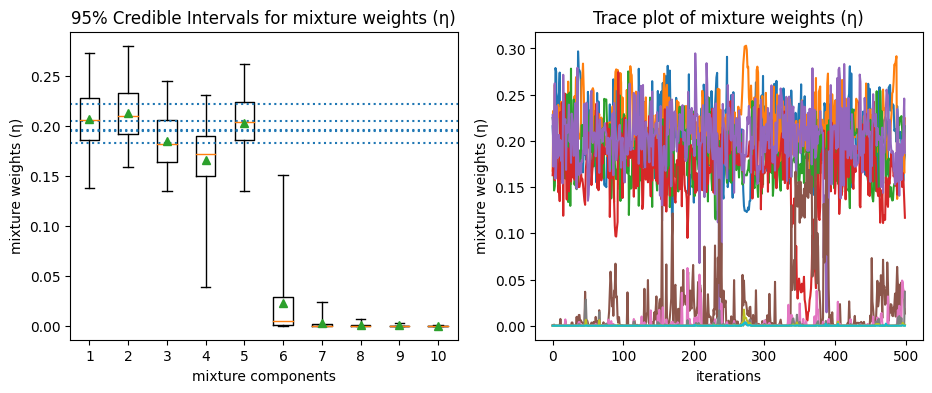

In [43]:
plot_param_post(etapost, :eta, "mixture weights (η)", truth=data[:w]);

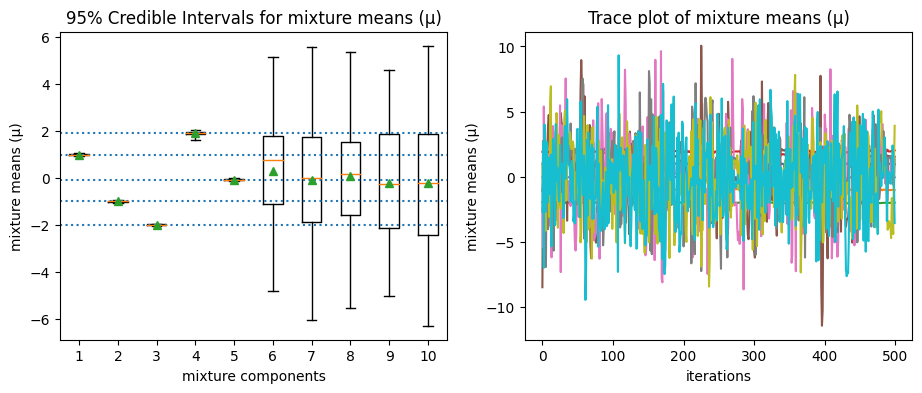

In [44]:
plot_param_post(mupost, :mu, "mixture means (μ)", truth=data[:mu]);

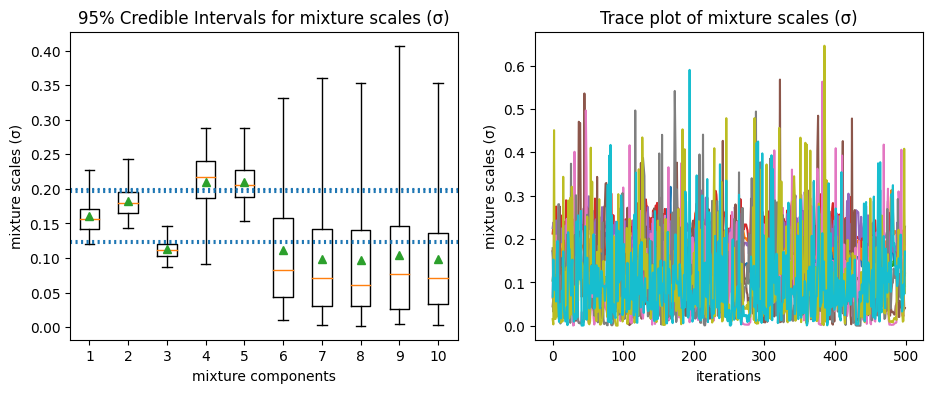

In [45]:
plot_param_post(sigpost, :sigma, "mixture scales (σ)", truth=data[:sig]);

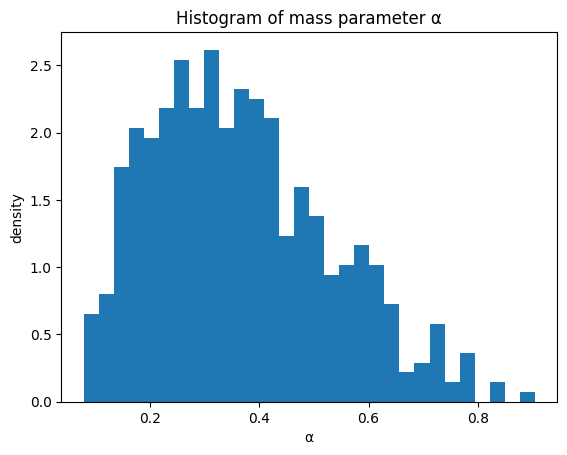

In [47]:
plt.hist(vec(chain[:alpha].value), density=true, bins=30)
plt.xlabel("α")
plt.ylabel("density")
plt.title("Histogram of mass parameter α");